In [68]:
%pylab inline
import time
import numpy as np
import os

import cPickle as pickle
import hashlib

from sigvisa.database.dataset import read_timerange, read_events, EV_MB_COL, EV_EVID_COL
from sigvisa.signals.io import load_event_station_chan, load_segments, fetch_waveform, MissingWaveform
from sigvisa.signals.common import Waveform
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_sg, initialize_from, do_inference
from sigvisa.infer.run_mcmc import run_open_world_MH
from sigvisa.infer.mcmc_logger import MCMCLogger
from sigvisa.models.ttime import tt_predict
from sigvisa import Sigvisa
from sigvisa.source.event import get_event, Event

from sigvisa.graph.sigvisa_graph import SigvisaGraph

Populating the interactive namespace from numpy and matplotlib


In [253]:
#stas = ["WR1", "FITZ", "AS12"]
#stas = "AS12,WR1,MK31,YKR8,IL31,TOA0,FITZ,KURBB,SONA0,BVA0,CTA,CM16,ZAA0,AKTO,INK,STKA,FIA0,KS31,ARA0,NV01,NB200,PEA0,BR131,LPAZ,USA0,VNDA,URZ,PMG,KBZ,AAK,AKBB,DZM,PLCA,JKA,CPUP".split(",")
stas = "AKTO,AS12,BVA0,CM16,CTA,FITZ,KURBB,SONA0,WR1,ZAA0".split(",") # , YKR8, INK, IL31
print stas
ms = ModelSpec(template_model_type="param",max_hz=10.0,
               wiggle_family="dummy",
               wiggle_model_type="dummy",
               skip_levels=2,)

s = Sigvisa()
ev = get_event(evid=5302220)# 5301163
#ev = Event(lon=129.0, lat=-3.0, depth=0.0, mb=3.5, time=1240250347.0)
ev.mb=3.4

bad_ev = Event(lon=ev.lon+5.0, lat=ev.lat-5.0, depth=ev.mb, mb=ev.mb, time=ev.time)

sg = SigvisaGraph(runids=(37,), **ms.sg_params)
for sta in stas:
    print sta
    atime = tt_predict(ev, sta, "P") + ev.time
    d = np.zeros((4600),)
    w = Waveform(stime=atime-60, etime=atime+400, srate=10.0, 
                 sta=sta, chan=s.default_vertical_channel[sta], 
                 band="freq_0.8_4.5",
                 data=d).filter("freq_0.8_4.5;env")
    sg.add_wave(w, disable_conflict_checking=False, fixed=False)

sg.add_event(ev)

['AKTO', 'AS12', 'BVA0', 'CM16', 'CTA', 'FITZ', 'KURBB', 'SONA0', 'WR1', 'ZAA0']
AKTO
AS12
BVA0
CM16
CTA
FITZ
KURBB
SONA0
WR1
ZAA0


{'depth': <NODE 1;loc>,
 'lat': <NODE 1;loc>,
 'loc': <NODE 1;loc>,
 'lon': <NODE 1;loc>,
 'mb': <NODE 1;mb>,
 'natural_source': <NODE 1;source>,
 'time': <NODE 1;time>}

In [258]:
sg.fix_event(1)
for n in sg.all_nodes.values():
    if "mult_wiggle_std" in n.label:
        try:
            n.set_value(0.01)
        except:
            continue
        n.fix_value()
        
    if "amp_transfer" in n.label:
        ch = [nn for nn in n.children if "coda_height" in nn.label][0]
        wn = [nn for nn in ch.children if "wave" in nn.label][0]
        lognoise = np.log(wn.nm.c)
        coda_height = lognoise -.1 #+ np.random.randn() * .2
        n.unfix_value()
        n.set_value(coda_height+ev.mb)
        n.fix_value()
np.random.seed(50) # 23
sg.parent_sample_all()



sampling w/ seed 1510818395
sampling w/ seed 487176764
sampling w/ seed 1852545115
sampling w/ seed 1710983511
sampling w/ seed 767163616
sampling w/ seed 2032623028
sampling w/ seed 1278869929
sampling w/ seed 238735774
sampling w/ seed 439715209
sampling w/ seed 1073080462


In [259]:
for wns in sg.station_waves.values():
    wn = wns[0]
    try:
        v, _ = wn.get_template_params_for_arrival(1, "P")
    except:
        print "no arrival at", wn.sta, wn.st, wn.et
        continue
    
    lognoise = np.log(wn.nm.c)
    snr = v["coda_height"] - lognoise
    print wn.sta, v["coda_height"], lognoise, snr

CM16 0.498743415096 0.386625951685 0.112117463411
BVA0 -0.210198148554 -0.322315611965 0.112117463411
AKTO -0.571772499711 -0.683889963122 0.112117463411
ZAA0 -1.62754319554 -1.73966065896 0.112117463411
FITZ -0.591182563307 -0.703300026718 0.112117463411
CTA 0.343992916466 0.231875453055 0.112117463411
WR1 -0.247974127768 -0.360091591179 0.112117463411
SONA0 -0.1077286143 -0.219846077711 0.112117463411
KURBB 6.19406346313 6.08194599972 0.112117463411
AS12 -0.357647568702 -0.469765032112 0.112117463411


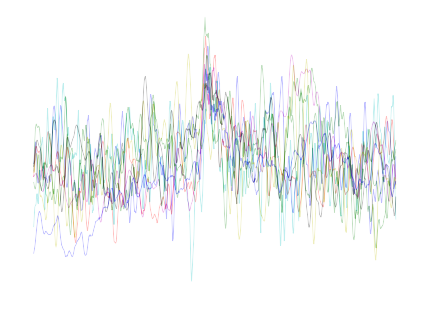

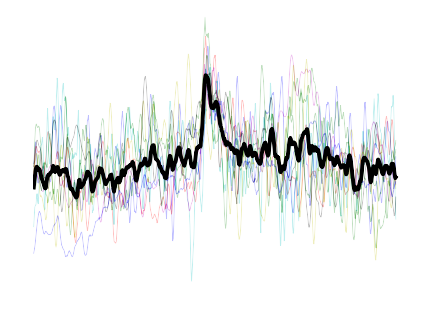

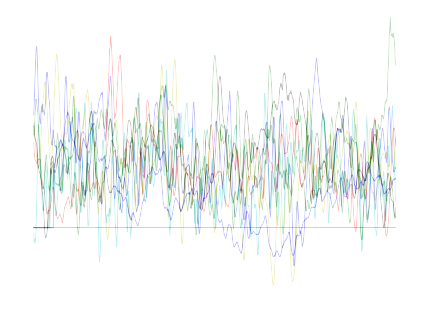

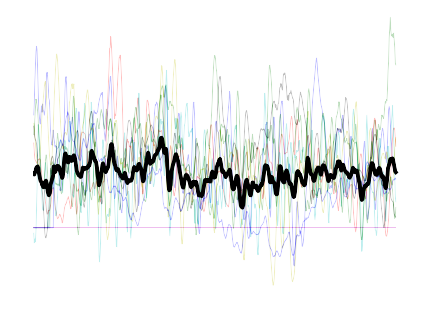

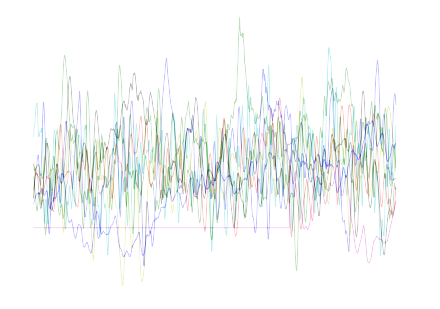

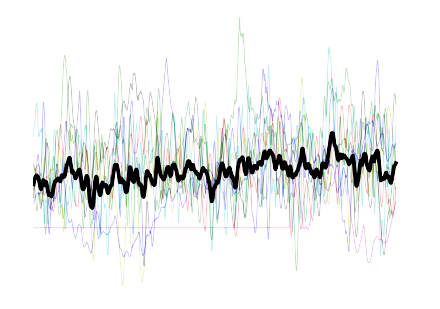

In [260]:
def aligned_arrival(wn, ev=None):
    d = wn.get_value()
    if ev is None:
        v, _ = wn.get_template_params_for_arrival(1, "P")
        atime = v["arrival_time"] #+ np.exp(v["peak_offset"])
    else:
        atime = tt_predict(ev, sta, "P") + ev.time
    at_idx = int((atime-wn.st)*wn.srate)
    sidx = at_idx - 300
    eidx = at_idx + 350
    s = np.zeros(650)
    d_sidx = max(0, sidx)
    s_sidx = max(0, -sidx)
    
    d_eidx = min(len(d), eidx)
    s_eidx = min(650, len(d)-sidx)
    try:
        if d_eidx > 0 and s_eidx > 0:
            s[s_sidx:s_eidx] = d[d_sidx:d_eidx]
    except:
        import pdb; pdb.set_trace()
    return (s - wn.nm.c)/wn.nm.c
    
def plot_alignment(ev=None, plot_individual=False): # FITZ
    stas = "AKTO,AS12,BVA0,CM16,CTA,KURBB,SONA0,WR1,ZAA0".split(",") # , YKR8, INK, IL31
    aligned = [aligned_arrival(sg.station_waves[sta][0], ev=ev) for sta in stas]
    if plot_individual:
        for d in aligned:
            figure()
            plot(d)
            plt.axvline(300, color="red")

        
    f = plt.figure(figsize=(7, 5))
    ax = f.add_subplot(111)
    for d in aligned:
        ax.plot(d, alpha=0.5)
    ax.axis("off")
    
    aligned_mean = np.mean(aligned, axis=0)
    f = plt.figure(figsize=(7, 5))
    ax = f.add_subplot(111)
    for d in aligned:
        ax.plot(d, alpha=0.5)
    plot(aligned_mean, lw=4, color="black")
    ax.axis("off")    

plot_alignment()
plot_alignment(ev=ev)
plot_alignment(ev=bad_ev)

AKTO 6 6 58.0164 50.4348
AS12 6 6 133.90573 -23.664895
BVA0 6 6 70.3885 53.0249
CM16 6 6 98.942992 18.457454
CTA 6 6 146.25 -20.0876
FITZ 6 6 125.6403 -18.09826
KURBB 6 6 78.53039 50.62264
SONA0 6 6 106.39499 47.83469
WR1 6 6 134.33951 -19.942589
ZAA0 6 6 84.818807 53.948063
AKTO 6 6 58.0164 50.4348
AS12 6 6 133.90573 -23.664895
BVA0 6 6 70.3885 53.0249
CM16 6 6 98.942992 18.457454
CTA 6 6 146.25 -20.0876
FITZ 6 6 125.6403 -18.09826
KURBB 6 6 78.53039 50.62264
SONA0 6 6 106.39499 47.83469
WR1 6 6 134.33951 -19.942589
ZAA0 6 6 84.818807 53.948063


(0.0, 180.0, -60.0, 80.0)

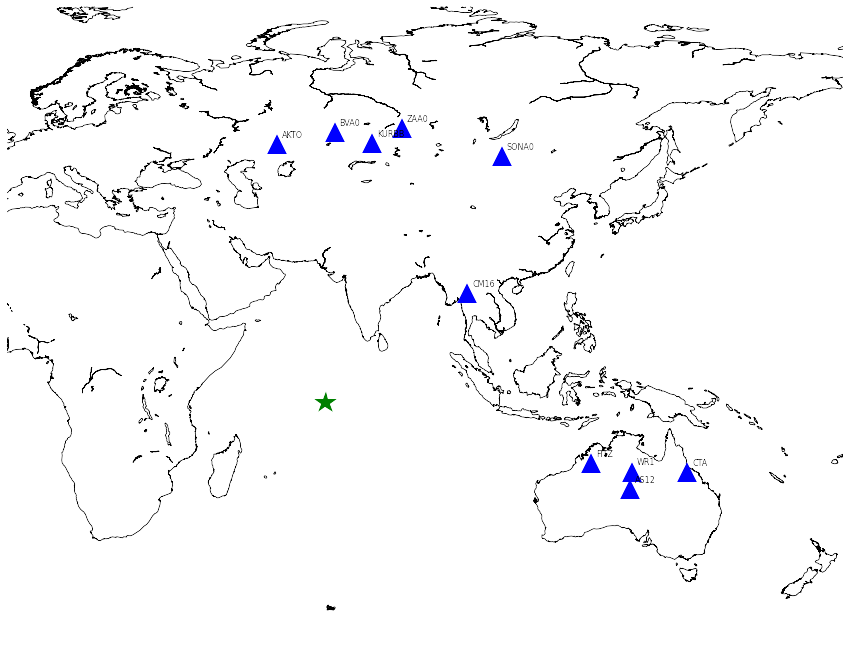

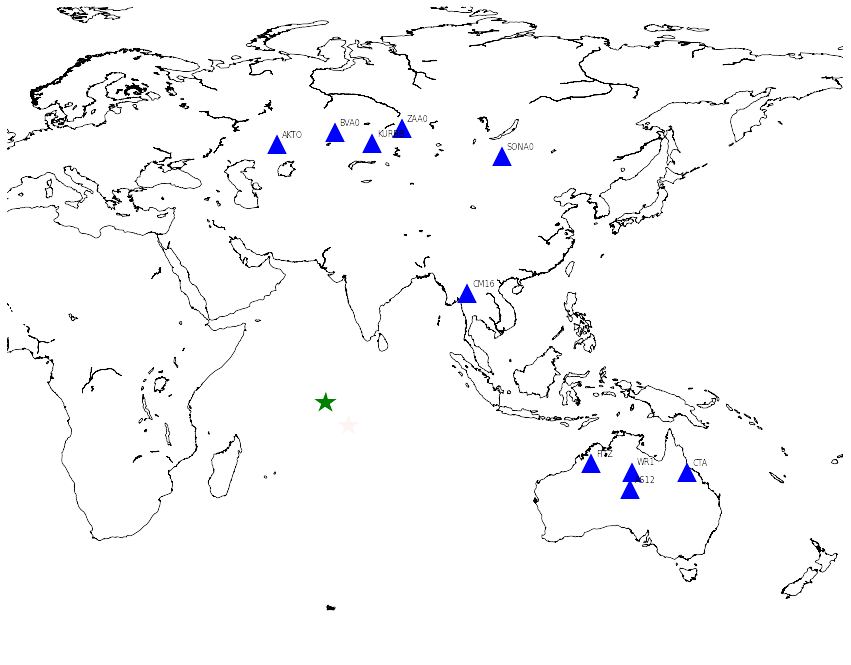

In [261]:
from sigvisa.plotting.event_heatmap import EventHeatmap
hm = EventHeatmap(f=None, calc=False, left_lon=-0, right_lon=180, bottom_lat=-60, top_lat=80)
#hm.add_stations(stas)


f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111)
#hm.plot(label_stations=True, axes=ax)
sta_locations = [s.earthmodel.site_info(n, 0)[0:2] for n in stas]
hm.init_bmap(axes=ax)
hm.plot_locations(sta_locations, labels=stas,
                    marker="^", ms=20, mec="none", mew=0,
                    alpha=1.0, mfc="blue")
hm.plot_locations([(ev.lon, ev.lat)],
                    marker="*", ms=24, mec="none", mew=0,
                    alpha=1.0, mfc="green")

ax.axis("off")


f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111)
#hm.plot(label_stations=True, axes=ax)
sta_locations = [s.earthmodel.site_info(n, 0)[0:2] for n in stas]
hm.init_bmap(axes=ax)
hm.plot_locations(sta_locations, labels=stas,
                    marker="^", ms=20, mec="none", mew=0,
                    alpha=1.0, mfc="blue")
hm.plot_locations([(ev.lon, ev.lat)],
                    marker="*", ms=24, mec="none", mew=0,
                    alpha=1.0, mfc="green")
hm.plot_locations([(bad_ev.lon, bad_ev.lat)],
                    marker="*", ms=24, mec="none", mew=0,
                    alpha=0.2, mfc="red")
ax.axis("off")

(1238936725.2175004,
 1238936790.2175004,
 -0.059999999999999998,
 0.059999999999999998)

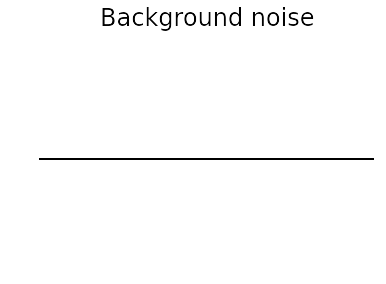

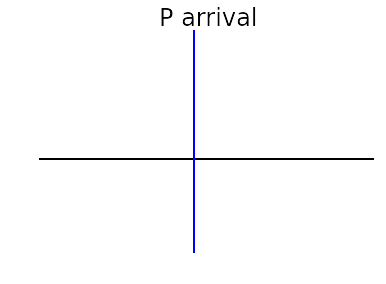

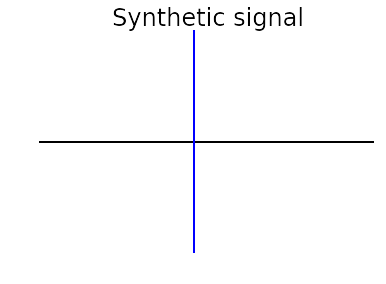

In [248]:
wn = sg.station_waves["AKTO"][0]
t = np.linspace(wn.st, wn.et, wn.npts)
v = wn.get_value()
pp = wn.tssm.mean_obs(wn.npts)


f = plt.figure()
ax = f.add_subplot(111)
ax.plot(t, v-pp, color="black", lw=2)
ax.set_title("Background noise", fontsize=24)
ax.set_xlim([wn.st + 30, wn.st+95])

ax.axis("off")

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(t, v-pp, color="black", lw=2)
ax.set_xlim([wn.st + 30, wn.st+95])
ax.set_title("P arrival", fontsize=24)
plt.axvline(wn.st + 60, color="blue", lw=2)
ax.axis("off")

f = plt.figure()
ax = f.add_subplot(111)
from sigvisa.plotting.plot import plot_with_fit_shapes
shape_colors={1: (0.0, 0.0, 1.0)}
shape_colors = plot_with_fit_shapes(fname=None, wn=wn, axes=ax, plot_wave=False, shape_colors=shape_colors)
ax.plot(t, v, color="blue", lw=2)
plt.axvline(wn.st + 60, color="blue", lw=2)
ax.plot(t, v-pp+wn.nm.c, color="black", lw=2)
ax.set_title("Synthetic signal", fontsize=24)
ax.set_xlim([wn.st + 30, wn.st+95])
ax.axis("off")


f = plt.figure()
ax = f.add_subplot(111)
from sigvisa.plotting.plot import plot_with_fit_shapes
ax.plot(t, v, color="black", lw=2)
plt.axvline(wn.st + 60, color="blue", lw=2)
#ax.plot(t, v-pp+wn.nm.c, color="black", lw=2)
ax.set_title("Synthetic signal", fontsize=24)
ax.set_xlim([wn.st + 30, wn.st+95])
ax.axis("off")

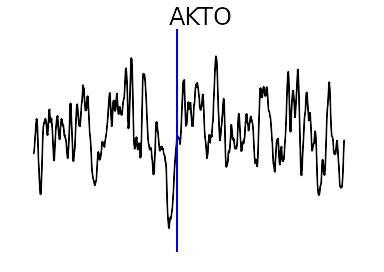

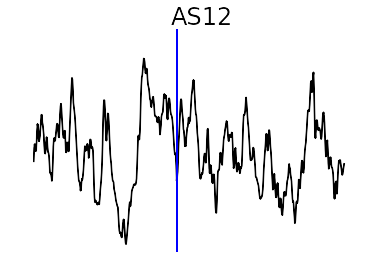

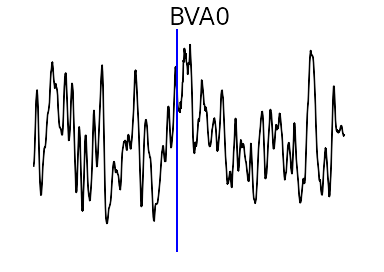

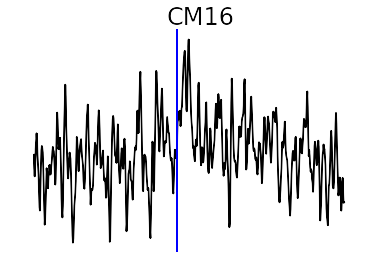

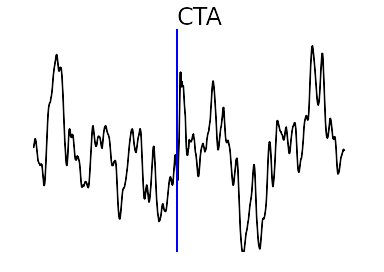

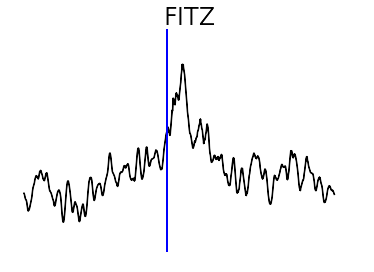

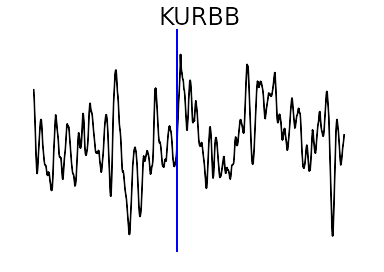

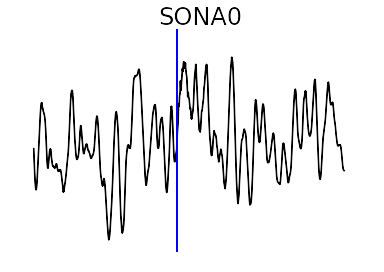

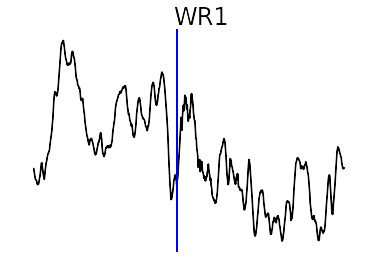

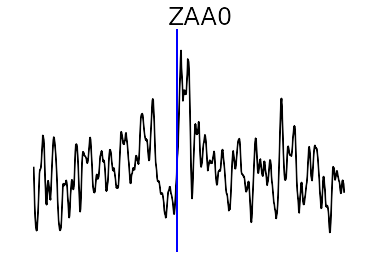

In [237]:
for sta in stas:
    wn = sg.station_waves[sta][0]
    d = aligned_arrival(sg.station_waves[sta][0])
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.plot(d, color="black", lw=2)
    ax.set_title(sta, fontsize=24)
    plt.axvline(300, color="blue", lw=2)
    ax.axis("off")
    